In [1]:
from databases import Database
from sketch.api import data


database = Database(
    "sqlite+aiosqlite:///../../test.db",
)

pf = await data.get_portfolio(database, 'justin')

In [6]:
import pandas as pd
import json

test = pd.Series({k: json.dumps(v.to_dict()) for k, v in pf.sketchpads.items()})
test.to_parquet("349082_wikitable.parquet")

AttributeError: 'Series' object has no attribute 'to_parquet'

In [8]:
df = test.to_frame()

In [12]:
df.columns = ["sketchpad_data"]
df.index.name = "sketchpad_id"

In [18]:
df.to_parquet("349082_wikitable.parquet", compression="gzip")

In [19]:
!ls -lh 349082_wikitable.parquet

-rw-r--r--  1 jawaugh  staff   217M Aug 20 21:44 349082_wikitable.parquet


In [ ]:
# 300 MB -> 200 MB gzip compression on 349082 sketchpad scale


In [22]:
import numpy as np
import altair as alt
cards = np.array(
    [
        x.get_sketchdata_by_name("HyperLogLog").count()
        for x in pf.sketchpads.values()
    ]
)
# hist, bins = np.histogram(cards)
upper = pow(2, np.ceil(np.log(np.max(cards) / np.log(2))))
bins = np.geomspace(1, upper, num=100)
hist, *_ = np.histogram(cards, bins=bins)
# should be geometric mean...
df = pd.DataFrame({"x": bins[:-1], "x1": bins[1:], "y": hist})
chart = (
    alt.Chart(df)
    .mark_bar()
    .encode(
        x=alt.X(
            "x", title="Unique Count", scale=alt.Scale(type="log", domainMin=1)
        ),
        # x2="x2",
        # y=alt.Y("y", title="Number", scale=alt.Scale(type="log")),
        y=alt.Y("y", title="Count"),
    )
    .properties(width="container", height=300)
)

[-1.52366976 12.59429358]


[]

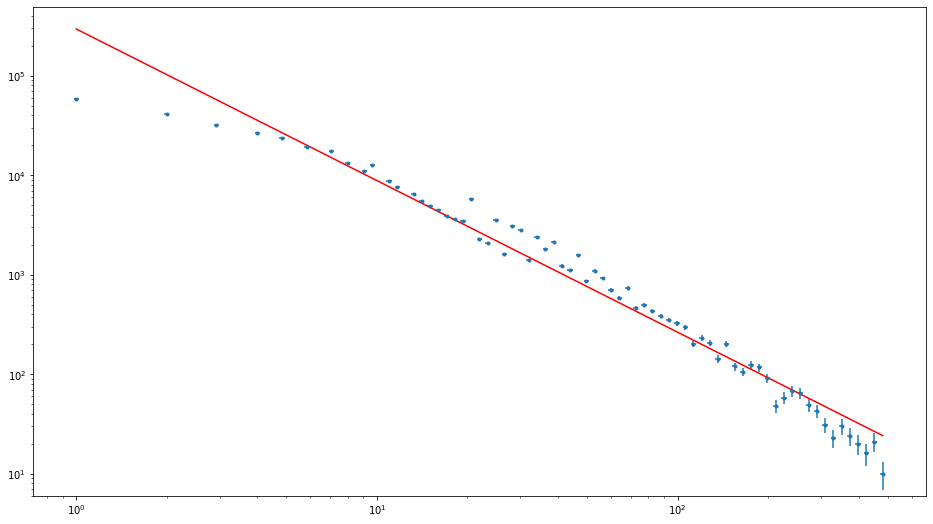

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.errorbar(df['x'], df['y'], xerr=0.02*df['x'], yerr=np.sqrt(df['y']), linestyle='None', marker='.')

x, y = zip(*[(x, y) for x, y in zip(df['x'], df['y']) if y > 0])
# print(x, y)
z = np.polyfit(np.log(x), np.log(y), 1)
fit_data = np.poly1d(z)(np.log(x))
plt.loglog(x, np.exp(fit_data), 'r-',)
print(z)
plt.plot()

In [ ]:
# Database consideration -> always have a parquet "rolling source" or something, something that is the serialized tape
#  -> its off of that (read many) that a bunch of things can be calculated.
#  -> can have lots of "named" rolling-sources. 